# Start: loading the necessary packages

In [6]:
# make sure matplotlib shows images inline
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import cv2
import random
from PIL import Image

# Keras packages
from keras import layers
from keras.layers import Input,Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K

# Define some functions we'll use later in the script
* read images 
* resize images

ATTENTION: all images should have the same aspect ratio and the same orientation (either all landscape OR all portrait)

In [7]:
# define a function that reads images from a location and uses the image names as labels
def read_images(imgloc = ''):
    # read all images from file into a numpy array
    # cv2 assumes colors are BGR, so we also convert this to RGB
    images = np.array([cv2.cvtColor(cv2.imread(imgloc + name), cv2.COLOR_BGR2RGB) for name in os.listdir(imgloc)], dtype = np.object)

    # use the image names to create a numpy array with the label of each image
    labels  = np.array([str(name.rpartition(' ')[0].rpartition('_')[2]) for name in os.listdir(imgloc)])
    
    return images, labels

def resize_images(img, basewidth = 64):
    # make sure the numpy array contains integers (otherwise we can't convert them to PIL images)
    img = img.astype('uint8')
    #plt.imshow(img)
    
    # convert the numpy array image to PIL image
    img = Image.fromarray(img)
    #print(type(img))

    # calculate the height, based on the preferred width
    hsize = int((float(img.size[1]) * float((basewidth / float(img.size[0])))))
    #print(hsize)

    # resize the image
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    #print(img.size)
    #plt.imshow(img)
    
    # convert the image to numpy array
    img = np.array(img)
    #print(type(img))
    
    return img

# Read images
Load all the images we want to use to train and evaluate the model

In [8]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the training data
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TRAIN/'
train_img, train_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 18 20:05:50 2018 

finish:  Sun Feb 18 20:06:15 2018 

this took --- 24.87 seconds ---


In [9]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# read the training data
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TEST/'
test_img, test_label = read_images(imgloc)

# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sun Feb 18 20:06:15 2018 

finish:  Sun Feb 18 20:06:19 2018 

this took --- 3.64 seconds ---


In [9]:
print(train_img.shape)
print(train_label.shape)
print(train_label)

print('\n')

print(test_img.shape)
print(test_label.shape)
print(test_label)

(41, 3968, 2976, 3)
(41,)
['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C']


(6, 3968, 2976, 3)
(6,)
['A' 'A' 'B' 'B' 'C' 'C']


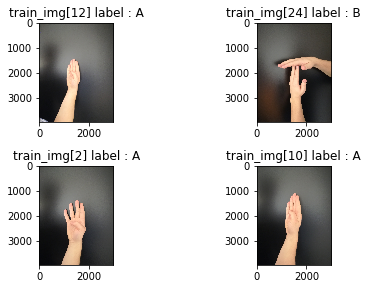

In [10]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
plt.imshow(train_img[samp[0]].astype('uint8'))

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
plt.imshow(train_img[samp[1]].astype('uint8'))

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
plt.imshow(train_img[samp[2]].astype('uint8'))

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
plt.imshow(train_img[samp[3]].astype('uint8'))

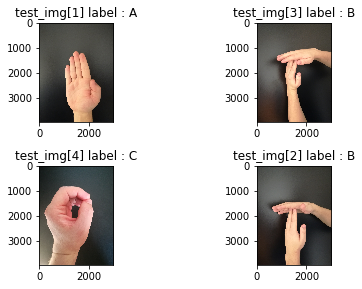

In [11]:
# let's take a look at some of the images (test)

# randomly pick 4 of the images
samp = random.sample(range(0,len(test_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
plt.imshow(test_img[samp[0]].astype('uint8'))

plt.subplot(2,2,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
plt.imshow(test_img[samp[1]].astype('uint8'))

plt.subplot(2,2,3)
plt.title('test_img[' + str(samp[2]) + '] label : ' + str(test_label[samp[2]]))
plt.imshow(test_img[samp[2]].astype('uint8'))

plt.subplot(2,2,4)
plt.title('test_img[' + str(samp[3]) + '] label : ' + str(test_label[samp[3]]))
plt.imshow(test_img[samp[3]].astype('uint8'))

# Resize images
It doesn't matter which size the images are at the start, we'll try to scale them down here for the sake of efficiency

In [12]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in train_img:
    # resize the numpy array images
    img = resize_images(img, basewidth)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sat Feb 17 14:50:10 2018 

finish:  Sat Feb 17 14:50:47 2018 

this took --- 36.75 seconds ---


In [13]:
# convert the list with images back to a numpy array
train_img = np.array(img_list)
print(train_img.shape)

(41, 85, 64, 3)


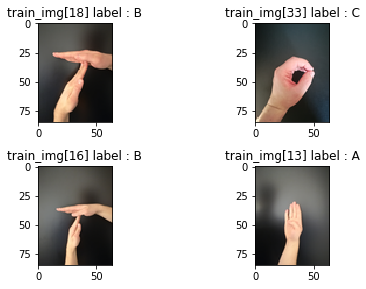

In [14]:
# let's take a look at some of the images (train)

# randomly pick 4 of the images
samp = random.sample(range(0,len(train_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('train_img[' + str(samp[0]) + '] label : ' + str(train_label[samp[0]]))
plt.imshow(train_img[samp[0]])

plt.subplot(2,2,2)
plt.title('train_img[' + str(samp[1]) + '] label : ' + str(train_label[samp[1]]))
plt.imshow(train_img[samp[1]])

plt.subplot(2,2,3)
plt.title('train_img[' + str(samp[2]) + '] label : ' + str(train_label[samp[2]]))
plt.imshow(train_img[samp[2]])

plt.subplot(2,2,4)
plt.title('train_img[' + str(samp[3]) + '] label : ' + str(train_label[samp[3]]))
plt.imshow(train_img[samp[3]])

In [15]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# resize the images
basewidth = 64
img_list = []

# loop through all the images in the data and resize them
for img in test_img:
    # resize the numpy array images
    img = resize_images(img, basewidth)
    # add the image to a list of numpy array images
    img_list.append(img)

#print(img_list)
    
# print the current datetime
print('finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

start:  Sat Feb 17 14:50:50 2018 

finish:  Sat Feb 17 14:50:55 2018 

this took --- 5.24 seconds ---


In [16]:
# convert the list with images back to a numpy array
test_img = np.array(img_list)
print(test_img.shape)

(6, 85, 64, 3)


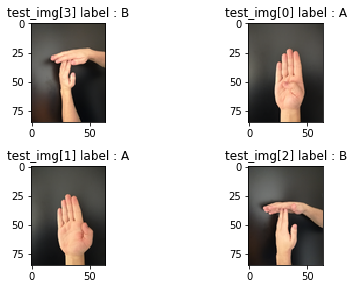

In [17]:
# let's take a look at some of the images (test)

# randomly pick 4 of the images
samp = random.sample(range(0,len(test_img)-1),4)

plt.subplots(2,2)
plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.10, right = 0.95, hspace = 0.45, wspace = 0.45)

plt.subplot(2,2,1)
plt.title('test_img[' + str(samp[0]) + '] label : ' + str(test_label[samp[0]]))
plt.imshow(test_img[samp[0]])

plt.subplot(2,2,2)
plt.title('test_img[' + str(samp[1]) + '] label : ' + str(test_label[samp[1]]))
plt.imshow(test_img[samp[1]])

plt.subplot(2,2,3)
plt.title('test_img[' + str(samp[2]) + '] label : ' + str(test_label[samp[2]]))
plt.imshow(test_img[samp[2]])

plt.subplot(2,2,4)
plt.title('test_img[' + str(samp[3]) + '] label : ' + str(test_label[samp[3]]))
plt.imshow(test_img[samp[3]])

# Label matrix
The model needs a matrix where:
* the number of records = the number of images
* the number of columns = the number of possible values (labels) the images can represent

in this matrix all values will be 0 except for the column where the label is the label that specific image represents, there the value will be 1

In [18]:
# determine the number of unique labels
nr_possible_values = np.unique(train_label).size

# create a matrice with only zeros
# the number of rows = the number of images
# the number of columns = the number of possible values we want to recognize
label_matrix_train = np.zeros([train_label.shape[0], nr_possible_values])
label_matrix_test = np.zeros([test_label.shape[0], nr_possible_values])

# create a dictionary for the labels
# we're going to use this dictionary to determine which column in the matrix corresponds to which value
label_dict = {'A': 0, 'B': 1, 'C': 2}

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in train_label:
    label_matrix_train[count, label_dict[i]] = 1
    count = count + 1

# set the value of 1 for each record in the column with the corresponding value
count = 0
for i in test_label:
    label_matrix_test[count, label_dict[i]] = 1
    count = count + 1

#print(label_matrix_train)
print(label_matrix_test)

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


# Prepare the model
* normalize data
* define variables
* define funtions

In [19]:
# normalize the data (set all values between [0,1])
train_img_norm = train_img / 255
test_img_norm = test_img / 255

#print(train_img_norm)
print(test_img_norm)

[[[[ 0.24313725  0.24313725  0.21960784]
   [ 0.24705882  0.24705882  0.22352941]
   [ 0.25098039  0.24705882  0.23137255]
   ..., 
   [ 0.20784314  0.20784314  0.19215686]
   [ 0.20392157  0.2         0.18823529]
   [ 0.19607843  0.19607843  0.18431373]]

  [[ 0.24705882  0.25098039  0.22352941]
   [ 0.2627451   0.2627451   0.23921569]
   [ 0.26666667  0.2627451   0.24313725]
   ..., 
   [ 0.21960784  0.21568627  0.19607843]
   [ 0.21176471  0.20784314  0.18823529]
   [ 0.20392157  0.2         0.18039216]]

  [[ 0.25882353  0.25490196  0.23137255]
   [ 0.26666667  0.25882353  0.23529412]
   [ 0.27058824  0.2627451   0.24705882]
   ..., 
   [ 0.22745098  0.21960784  0.20392157]
   [ 0.21960784  0.21568627  0.2       ]
   [ 0.21176471  0.20784314  0.18823529]]

  ..., 
  [[ 0.09019608  0.09019608  0.09019608]
   [ 0.08627451  0.08627451  0.09019608]
   [ 0.08235294  0.08235294  0.08235294]
   ..., 
   [ 0.10196078  0.10196078  0.09803922]
   [ 0.10588235  0.10588235  0.10196078]
   [ 0.

In [20]:
# make sure to tell keras the channels are the last dimension in the shape of the dataset
# in this case the channel = 3, since we have full color images with 3 RGB channels
K.set_image_data_format('channels_last')



def plain_layer(X,n_c):
    X_in = X
    X = Conv2D(n_c,kernel_size = (3,3), padding = 'same')(X_in)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (2,2))(X)
    return X



def identity_block(X,F):
    X_in = X
    
    F1,F2,F3 = F
    
    X = Conv2D(F1,kernel_size=(3,3),padding='same')(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3,kernel_size=(3,3),padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_in = Conv2D(F3,kernel_size=(3,3),padding='same')(X_in)
    X_in = BatchNormalization(axis=3)(X_in)
    
    X = Add()([X,X_in])
    X = Activation('relu')(X)
    
    return X



def Resnet(input_shape = (85,64,3), classes = 6):
    X_in = Input(input_shape)
    
    X = plain_layer(X_in,32)
    
    F1 = [16,16,32]
    X = identity_block(X,F1)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F2 = [16,16,32]
    X = identity_block(X,F2)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    F3 = [16,16,32]
    X = identity_block(X,F3)
    #X = MaxPooling2D(pool_size=(2,2))(X)
    
    #X = plain_layer(X,32)
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(512,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(classes,activation='softmax')(X)
    
    model = Model(inputs=X_in,outputs=X,name='Resnet')
    return model

# Train the model

In [21]:
# determine the shape of the images
img_shape = train_img_norm.shape[1:4]

# declare a resnet model
my_model = Resnet(input_shape = img_shape, classes = nr_possible_values)

# print the current date and time
start = time.time()
print('start: ', str(time.ctime()), '\n')

my_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
my_model.fit(x = train_img_norm, y = label_matrix_train, epochs = 20, batch_size = 32)

# print the current date and time
print('\n', 'finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

time.sleep(5)

start:  Sat Feb 17 14:50:58 2018 

Epoch 1/20
41/41 [==============================] - 7s 161ms/step - loss: 1.5297 - acc: 0.6098
Epoch 2/20
41/41 [==============================] - 3s 70ms/step - loss: 10.9731 - acc: 0.2927
Epoch 3/20
41/41 [==============================] - 3s 69ms/step - loss: 8.0802 - acc: 0.4634
Epoch 4/20
41/41 [==============================] - 3s 68ms/step - loss: 7.0762 - acc: 0.5610
Epoch 5/20
41/41 [==============================] - 3s 69ms/step - loss: 7.0762 - acc: 0.5610
Epoch 6/20
41/41 [==============================] - 3s 69ms/step - loss: 7.0772 - acc: 0.5610
Epoch 7/20
41/41 [==============================] - 3s 71ms/step - loss: 7.3696 - acc: 0.5122
Epoch 8/20
41/41 [==============================] - 3s 69ms/step - loss: 7.0762 - acc: 0.5610
Epoch 9/20
41/41 [==============================] - 3s 69ms/step - loss: 7.0762 - acc: 0.5610
Epoch 10/20
41/41 [==============================] - 3s 69ms/step - loss: 7.0762 - acc: 0.5610
Epoch 11/20
41/41 [===

# Evaluate the model

In [22]:
# evaluate the model on the training data
my_model.evaluate(train_img_norm, label_matrix_train, batch_size = 32)

## ??!!??!! WERKT DIT WEL ??!!??!! ##

41/41 [==============================] - 1s 28ms/step


[7.0762371958755867, 0.56097561120986938]

In [23]:
# evaluate the model on the test data
pred = my_model.predict(test_img_norm)
pred_label = np.argmax(pred ,axis = 1)

# create an empty list for the labels
pred_label_translated = []

# translate the labels using the dictionary
for i in pred_label:
    pred_label_translated.append(list(label_dict.keys())[list(label_dict.values()).index(i)])

print(pred)
print(pred_label)
print(pred_label_translated)
print(test_label)

# create a classification report
print(classification_report(test_label, pred_label_translated))

## ??!!??!! TESTEN MET MEER DAN TWEE VERSCHILLENDE LABELS ??!!??!! ##

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.55207513e-33   0.00000000e+00   1.00000000e+00]
 [  1.65170595e-14   0.00000000e+00   1.00000000e+00]]
[0 0 0 0 2 2]
['A', 'A', 'A', 'A', 'C', 'C']
['A' 'A' 'B' 'B' 'C' 'C']
             precision    recall  f1-score   support

          A       0.50      1.00      0.67         2
          B       0.00      0.00      0.00         2
          C       1.00      1.00      1.00         2

avg / total       0.50      0.67      0.56         6



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Save the model to disk
This way we can use the model on other computers

In [24]:
# location to save the model
imgloc = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/'

# serialize model to JSON and save it
my_model_json = my_model.to_json()
with open(imgloc + "my_model.json", "w") as json_file:
    json_file.write(my_model_json)

# serialize weights to HDF5
my_model.save_weights(imgloc + "my_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# keras heeft een data generator functie --> uitzoeken hoe deze werkt!

In [190]:
def random_crop(image, crop_size):
    height, width = image.shape[0:2]
    dy, dx = crop_size
    if width < dx or height < dy:
        print('fail')
        return None
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return image[:, y:(y+dy), x:(x+dx)]

def image_generator(list_of_files, crop_size, to_grayscale=True, scale=1, shift=0):
    while True:
        filename = np.random.choice(list_of_files)
        try:
            img = img_to_array(load_img(filename, to_grayscale))
        except:
            return
        cropped_img = random_crop(img, crop_size)
        if cropped_img is None:
            continue
        yield scale * cropped_img - shift

def corrupted_training_pair(images, sigma):
    for img in images:
        target = img
        if sigma > 0:
            source = img + np.random.normal(0, sigma, img.shape)/255.0
        else:
            source = img
        yield (source, target)

def group_by_batch(dataset, batch_size):
    while True:
        try:
            sources, targets = zip(*[next(dataset) for i in xrange(batch_size)])
            batch = (np.stack(sources), np.stack(targets))
            yield batch
        except:
            return
        
def load_dataset(directory, crop_size, sigma, batch_size):
    files = image.list_pictures(directory)
    generator = image_generator(files, crop_size, scale=1/255.0, shift=0.5)
    generator = corrupted_training_pair(generator, sigma)
    generator = group_by_batch(generator, batch_size)
    return generator


In [156]:
patch_height = 85
patch_width = 64
noise_sigma = .05
batch_size = 32

train_set = load_dataset('C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TRAIN', (patch_height, patch_width), noise_sigma, batch_size)
val_set = load_dataset('C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TEST', (patch_height, patch_width), noise_sigma, batch_size)
#model.fit_generator(train_set, samples_per_epoch=batch_size * 1000, nb_epoch=nb_epoch, validation_data=val_set, nb_val_samples=1000)

<class 'numpy.ndarray'>
(85, 64, 3)


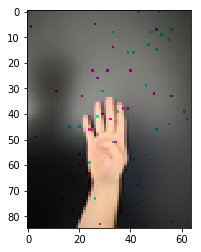

In [191]:
img = train_img[1]
print(type(img))
print(img.shape)
plt.imshow(img)

In [192]:
img = random_crop(img, [20,20])
#plt.imshow(img)
print(type(img))
print(img.shape)

32 8
<class 'numpy.ndarray'>
(85, 20, 0)


<class 'numpy.ndarray'>
(85, 64, 3)


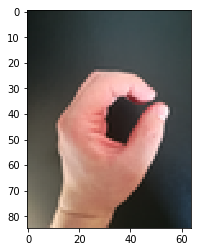

In [231]:
a = train_img[int(np.random.choice(len(train_img)))]
print(type(a))
print(a.shape)
plt.imshow(a)

In [232]:
int(np.random.choice(len(train_img)))

32

In [ ]:
# https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
# https://stackoverflow.com/questions/38155836/data-augmentation-image-data-generator-keras-semantic-segmentation
# https://tensorflow.rstudio.com/blog/keras-image-classification-on-small-datasets.html

# https://keras.io/preprocessing/image/

In [17]:
# create an augmented image generator
test_datagen = image.ImageDataGenerator(rescale = 1/255, rotation_range = 40, width_shift_range = 0.2, 
                                        height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                        horizontal_flip = True, fill_mode = "nearest")

print(type(test_datagen))

# After you have created and configured your ImageDataGenerator, you must fit it on your data. 
# This will calculate any statistics required to actually perform the transforms to your image data.
test_datagen.fit(test_img)

# The data generator itself is in fact an iterator, returning batches of image samples when requested. 
# We can configure the batch size and prepare the data generator and get batches of images by calling 
# the flow() function.
x_batch, y_batch, z_batch = test_datagen.flow(test_img, test_img, batch_size=32)

#test_datagen.flow_from_directory(directory = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TEST2', 
#                           target_size = [85, 64], color_mode = "rgb", 
#                           class_mode = "categorical", batch_size = 32, shuffle = True,
#                           seed = 1000, save_to_dir = 'C:/Users/cmoserveradmin/Desktop/HandSign_Recognition/00 Data/TEST2', 
#                           save_format = "jpg", interpolation = "nearest")

<class 'keras.preprocessing.image.ImageDataGenerator'>


ValueError: too many values to unpack (expected 3)

11493376/11490434 [==============================] - 4s 0us/step


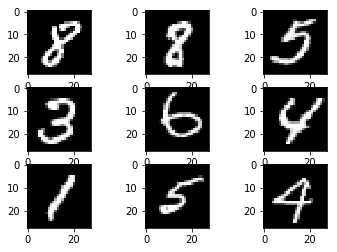

In [18]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

# Save augmented images to file
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import os
from keras import backend as K
K.set_image_dim_ordering('th')

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# define data preparation
datagen = ImageDataGenerator()

# fit parameters from data
datagen.fit(X_train)

# configure batch size and retrieve one batch of images
os.makedirs('images')
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='images', save_prefix='aug', save_format='png'):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [ ]:
# print the current datetime
print('start: ', str(time.ctime()), '\n')
start = time.time()

# create multiple copies of the existing images
# artificially creating more training examples
train_img_stack = np.empty_like (train_img_norm)
train_img_stack[:] = train_img_norm

train_label_stack = np.empty_like (label_matrix_train)
train_label_stack[:] = label_matrix_train

# print the shape of the array of images before starting
print(train_img_stack.shape)
print(train_label_stack.shape)

# add the existing array of images to the stack
# this way creating 100 copies of each image
for i in range(1,100):
    train_img_stack = np.vstack((train_img_stack, train_img_norm))
    #print(train_img_stack.shape)
    train_label_stack = np.vstack((train_label_stack, label_matrix_train)) 
    #print(train_label_stack)
    
# print the shape of the array of images after copying multiple times
print(train_img_stack.shape)
print(train_label_stack.shape)

# print the current datetime
print('\n finish: ', str(time.ctime()), '\n')
print("this took --- %s seconds ---" % round(time.time() - start, 2))

In [ ]:
train_img_norm = train_img_stack
label_matrix_train = train_label_stack